In [24]:
%load_ext autoreload
%autoreload 2

import os 
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [67]:
def read_in_data(data_dir):
    data_files = os.listdir(data_dir)
    run_data = []
    for data_file in data_files:
        with open(os.path.join(data_dir, data_file), encoding="utf-8") as file:
            metadata = data_file[:-4].split("_")
            if metadata[0][:3] != "exp":
                continue
            experiment_number = int(metadata[0][3:])
            number_runs = int(metadata[2])
            hadamard = len(metadata) == 4

            curr_data = np.zeros(number_runs)
            idx = 0
            for line in file.readlines():
                if "Error:" in line:
                    curr_data[idx] = float(line.split(" ")[2])
                    idx += 1
            
            run_data.append({
                "experiment_number": experiment_number,
                "number_runs": number_runs,
                "hadamard": hadamard,
                "data": curr_data
            })
    return run_data

def read_in_data_file(file_path):
    data_dir = os.path.join("rundata", "local")
    run_data = []
    with open(os.path.join(data_dir, file_path), encoding="utf-8") as file:
        curr_data = []
        experiment_number = 0
        number_runs = None
        hadamard = None

        for line in file:
            if "Index:" in line:
                # Process the previous experiment data if it exists
                if curr_data:
                    run_data.append({
                        "experiment_number": experiment_number + 1,
                        "number_runs": 512,
                        "hadamard": hadamard,
                        "data": np.array(curr_data)
                    })
                    curr_data = []
                continue

            if "Hadamard:" in line:
                hadamard = line.split(":")[1].strip().lower() == 'true'
                continue

            if "Experiment:" in line:
                experiment_number = int(line.split(":")[1].strip())
                continue

            # Process the error data lines
            if "Error:" in line:
                curr_data.append(float(line.split(" ")[2]))

        # Don't forget to add the last experiment's data
        if curr_data:
            run_data.append({
                "experiment_number": experiment_number + 1,
                "number_runs": number_runs,
                "hadamard": hadamard,
                "data": np.array(curr_data)
            })

    return run_data

exp_names = ['000, 001', '000, 110', '000, 111', '000, 010, 100', '000, 011, 100', '000, 011, 110', 'General Unitary']


def plot_combined_experiments(run_data, output_dir):
    # Prepare the data for the boxplot, only including 'No Hadamard' data
    no_hadamard_data = []
    experiment_labels = []
    
    # Filter and organize the data for plotting
    for run in run_data:
        if run['hadamard'] or run['experiment_number'] == len(exp_names):  # Skip the Hadamard data
            continue
        
        # Include only 'No Hadamard' data
        no_hadamard_data.extend(run['data'])
        experiment_labels.extend([exp_names[run['experiment_number'] - 1]] * len(run['data']))

    # Create a DataFrame for Seaborn
    df = pd.DataFrame({
        'Error Percentage': no_hadamard_data,
        'Experiment': experiment_labels
    })

    # Plotting
    plt.figure(figsize=(7,7))
    sns.boxplot(x='Experiment', y='Error Percentage', data=df)

    # Set the y-axis limits
    plt.ylim(0, 4)

    # Add a title
    plt.title('Experiment Results')

    # Improve the layout and save the plot
    plt.tight_layout()
    plt.savefig(os.path.join(output_dir, 'Combined_Experiments_Boxplot_No_Hadamard.png'), bbox_inches='tight')
    plt.show()
    plt.close()

    

def plot_experiments(run_data, output_dir):
    # Group data by experiment number

    plt.rcParams['lines.linewidth'] = 20  # Sets the line width
    
    grouped_data = {}
    for run in run_data:
        exp_num = run['experiment_number']
        key = (exp_num, run['hadamard'])
        if key not in grouped_data:
            grouped_data[key] = []
        grouped_data[key].extend(run['data'])

        # Create box and whisker plots
    for exp_num in set(key[0] for key in grouped_data):
        hadamard_data = grouped_data.get((exp_num, True), [])
        no_hadamard_data = grouped_data.get((exp_num, False), [])

        data_to_plot = []
        labels = []

        if hadamard_data:
            data_to_plot.append(hadamard_data)
            labels.append('Randomized')

        if no_hadamard_data:
            data_to_plot.append(no_hadamard_data)
            labels.append('Unrandomized')

        if not data_to_plot:  # Skip if no data is available
            continue

        plt.figure(figsize=(4, 4))
        plt.boxplot(data_to_plot, labels=labels, widths=0.4)
        plt.ylabel('Error Percentage')
        plt.ylim(0, 5) if no_hadamard_data[0] < 10 else plt.ylim(0, 100)
        if (hadamard_data is not None) ^ (no_hadamard_data is not None):
            plt.title(f'{exp_names[exp_num - 1]}')
        else:
            plt.title(f'{exp_names[exp_num - 1]}')
        plt.savefig(os.path.join(output_dir, f'Experiment_{exp_num}_Comparison.png'), bbox_inches='tight')
        plt.close()

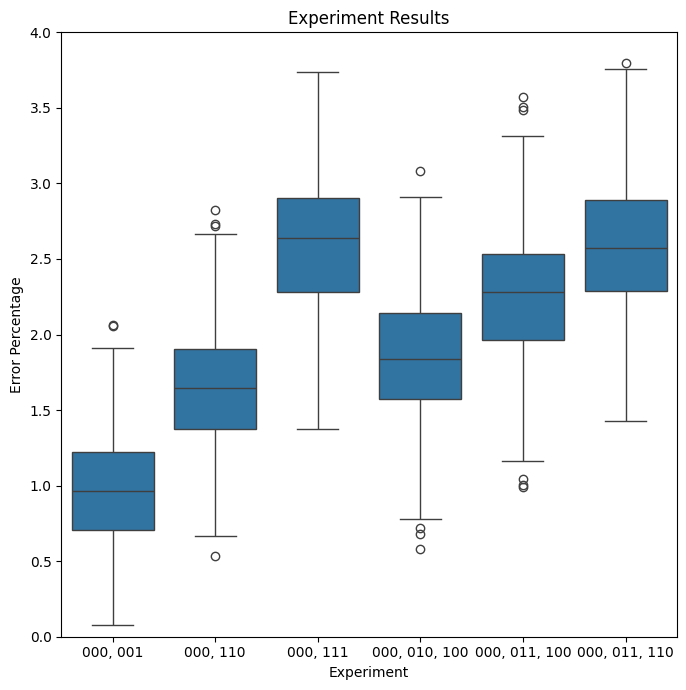

In [68]:
run_data = read_in_data(data_dir = os.path.join("rundata", "old_data"))
output_dir = os.path.join("rundata", "jmm_chart")
plot_combined_experiments(run_data, output_dir)

In [11]:
run_data = read_in_data()
output_dir = os.path.join("rundata", "charts")
plot_experiments(run_data, output_dir)

TypeError: read_in_data() missing 1 required positional argument: 'data_dir'

In [3]:
import pstats
p = pstats.Stats('profile')
p.sort_stats('cumulative').print_stats(100)

Fri Feb 23 16:38:11 2024    profile

         9223419 function calls (9058471 primitive calls) in 36.871 seconds

   Ordered by: cumulative time
   List reduced from 11545 to 100 due to restriction <100>

   ncalls  tottime  percall  cumtime  percall filename:lineno(function)
   2681/1    0.029    0.000   36.889   36.889 {built-in method builtins.exec}
        1    0.000    0.000   36.889   36.889 experiment.py:1(<module>)
        1    0.000    0.000   18.095   18.095 experiment.py:99(run)
        1    0.000    0.000   18.007   18.007 C:\Users\kevin\Research\tomography-repo\pure_state_tomography.py:49(pure_state_tomography)
        8    0.001    0.000   18.000    2.250 C:\Users\kevin\Research\tomography-repo\measurement_manager.py:716(measure_state)
        8    0.002    0.000   17.997    2.250 C:\Users\kevin\Research\tomography-repo\qutils.py:138(run_circuit)
       12    0.000    0.000   17.503    1.459 C:\Users\kevin\AppData\Local\Programs\Python\Python310\lib\threading.py:288(wait)